In [ ]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano

from scipy import stats
from sklearn.metrics import mean_squared_error
import math

import matplotlib.pyplot as plt
import arviz as az

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
d = pd.read_csv('data/foxes.csv', sep=';', header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


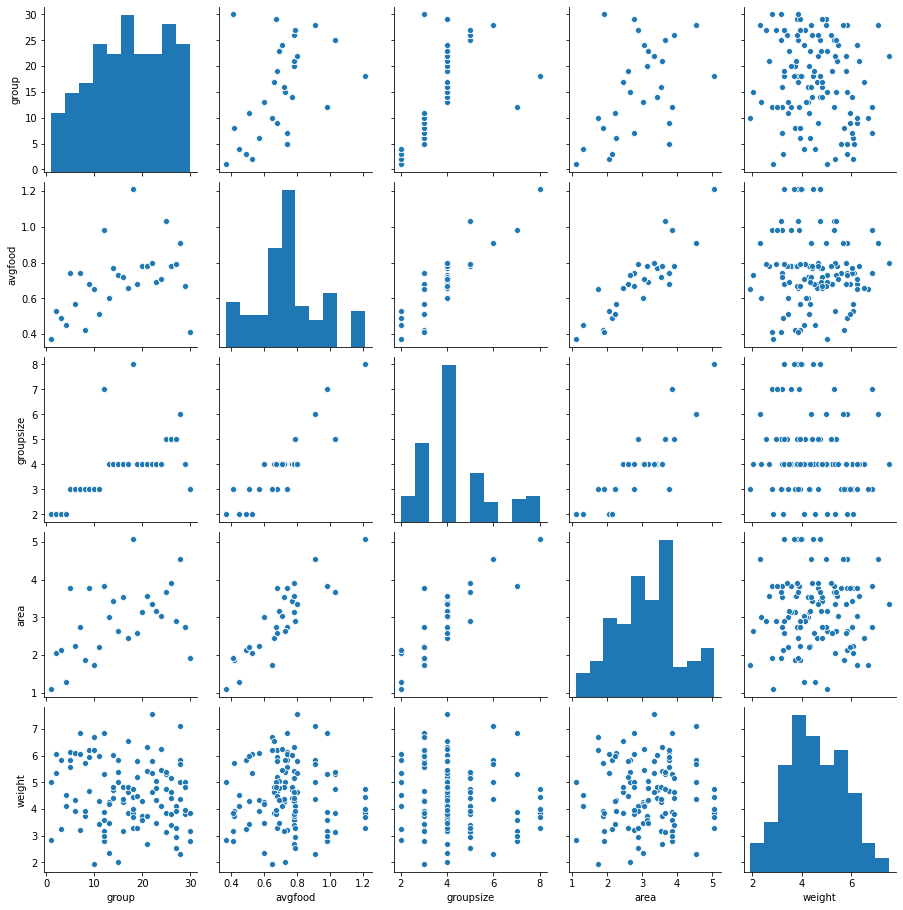

In [ ]:
sns.pairplot(d)

In [ ]:
d.dtypes

group          int64
avgfood      float64
groupsize      int64
area         float64
weight       float64
dtype: object

In [ ]:
d.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


### Excercise 1

In [ ]:
# with pm.Model() as model_ex1:
#     area = pm.Data('area', d.area.to_numpy())
#     avgfood = pm.Data('avgfood', d.avgfood.to_numpy())
#     groupsize = pm.Data('groupsize', d.groupsize.to_numpy())
#     weight = pm.Data('weight', d.weight.to_numpy())
    
#     β_area = pm.Normal("β_area", mu=0, sd=5)    
#     α_food = pm.Normal("α_food", mu=1, sd=1)
#     β_food = pm.Normal("β_food", mu= α_food + β_area * area, sd=1, observed=avgfood)
    
#     σ_weight = pm.Uniform("σ_weight", lower=0, upper=10)
#     μ = groupsize + β_food * avgfood
#     y_weight = pm.Normal('y_weight', mu=μ, sd=σ_weight, observed=weight)
    
#     prior = pm.sample_prior_predictive()
#     trace = pm.sample(draws=1000, tune=1000)
#     posterior = pm.sample_posterior_predictive(trace)

In [ ]:
from sklearn import preprocessing
d[['avgfood','groupsize','area','weight']] = preprocessing.scale(d[['avgfood','groupsize','area','weight']])
d.head()

,group,avgfood,groupsize,area,weight
0,1,-1.933180,-1.530701,-2.249313,0.415931
1,1,-1.933180,-1.530701,-2.249313,-1.433238
2,2,-1.122886,-1.530701,-1.210738,0.678887
3,2,-1.122886,-1.530701,-1.210738,1.306586
4,3,-1.325459,-1.530701,-1.135008,1.119973


In [ ]:
with pm.Model() as model_1:
    # Data
    area = pm.Data('area', d['area'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta = pm.Normal('beta', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta * area
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 100)
    posterior_1 = pm.sample()
    posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
az.summary(posterior_1, credible_interval=.89).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.00,0.09,-0.15,0.17,0.0,0.0,5089.0,2085.0,5060.0,3213.0,1.0
beta,0.02,0.09,-0.16,0.19,0.0,0.0,4980.0,1902.0,5016.0,2800.0,1.0
sigma,1.02,0.07,0.89,1.14,0.0,0.0,4772.0,4721.0,4853.0,2603.0,1.0


[]

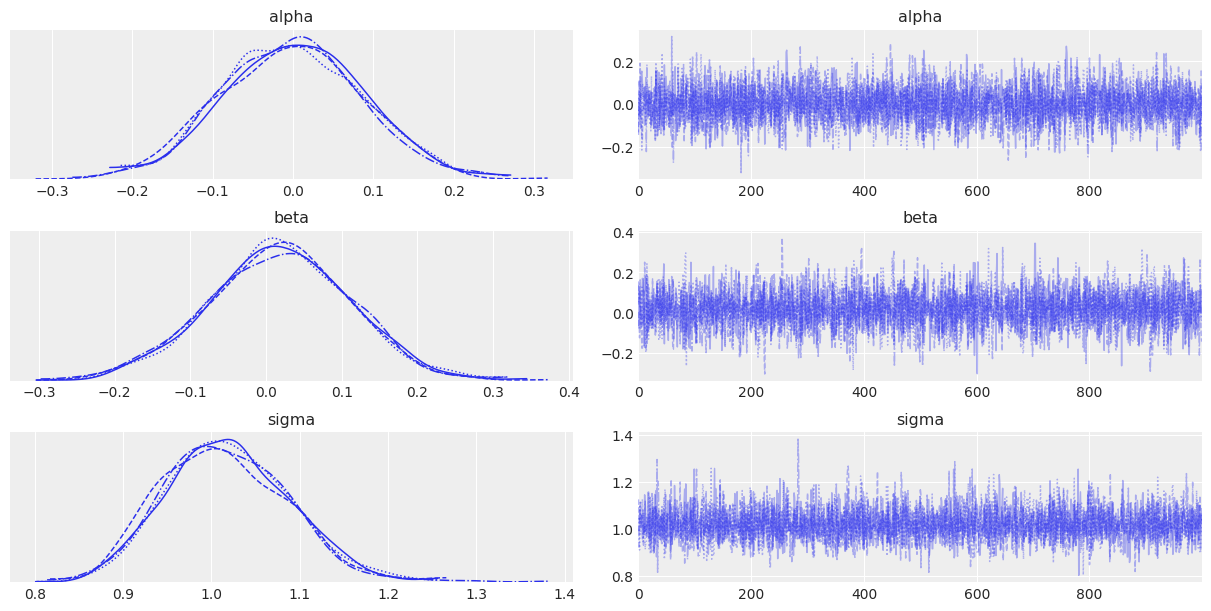

In [ ]:
pm.traceplot(posterior_1)
plt.plot()

##### Sample the priors

In [ ]:
df = pd.DataFrame()
df = df.assign(alpha = pd.Series(prior['alpha']),
               sigma = pd.Series(prior['sigma']),
               beta = pd.Series(prior['beta']))
df.shape

(100, 3)

In [ ]:
df.head()

,alpha,sigma,beta
0,-0.060416,1.175414,0.863810
1,-0.091506,1.728923,0.177399
2,0.054119,1.646499,0.262418
3,-0.178331,1.262668,0.240949
4,-0.226387,1.148817,0.163823


In [ ]:
priors = pd.DataFrame()
for i in range(df.shape[0]):
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i, 'beta'] * d['area']

In [ ]:
priors.shape

(116, 100)

In [ ]:
aux = pd.concat([d.area, priors], axis=1)
aux.head()

,area,prior_0,prior_1,prior_2,prior_3,prior_4,prior_5,prior_6,prior_7,prior_8,...,prior_90,prior_91,prior_92,prior_93,prior_94,prior_95,prior_96,prior_97,prior_98,prior_99
0,-2.249313,-2.003394,-0.490532,-0.536141,-0.720300,-0.594876,1.403864,-0.765834,-0.645399,0.514542,...,-0.674592,1.141839,2.541615,2.010648,-1.882595,0.342791,1.450985,1.118781,-0.500648,-1.553281
1,-2.249313,-2.003394,-0.490532,-0.536141,-0.720300,-0.594876,1.403864,-0.765834,-0.645399,0.514542,...,-0.674592,1.141839,2.541615,2.010648,-1.882595,0.342791,1.450985,1.118781,-0.500648,-1.553281
2,-1.210738,-1.106264,-0.306290,-0.263601,-0.470057,-0.424734,0.663631,-0.555597,-0.427382,0.366777,...,-0.393257,0.686633,1.413708,1.192425,-1.098155,0.197328,0.771332,0.561906,-0.391357,-0.910769
3,-1.210738,-1.106264,-0.306290,-0.263601,-0.470057,-0.424734,0.663631,-0.555597,-0.427382,0.366777,...,-0.393257,0.686633,1.413708,1.192425,-1.098155,0.197328,0.771332,0.561906,-0.391357,-0.910769
4,-1.135008,-1.040848,-0.292856,-0.243728,-0.451810,-0.412327,0.609655,-0.540268,-0.411485,0.356002,...,-0.372743,0.653441,1.331464,1.132763,-1.040956,0.186721,0.721775,0.521301,-0.383388,-0.863920


In [ ]:
aux_plot = aux.melt(id_vars=['area'], value_vars=list(aux.columns)[1:],
                    var_name='prior', value_name='weight')
aux_plot.shape

(11600, 3)

In [ ]:
aux_plot

,area,prior,weight
0,-2.249313,prior_0,-2.003394
1,-2.249313,prior_0,-2.003394
2,-1.210738,prior_0,-1.106264
3,-1.210738,prior_0,-1.106264
4,-1.135008,prior_0,-1.040848
...,...,...,...
11595,-0.453444,prior_99,-0.442272
11596,-0.453444,prior_99,-0.442272
11597,-1.362197,prior_99,-1.004469
11598,-1.362197,prior_99,-1.004469


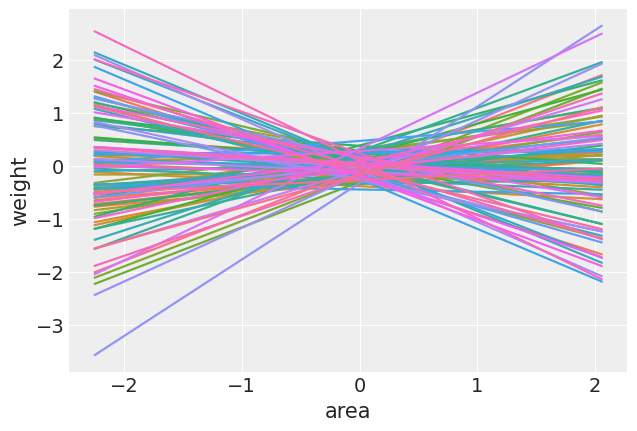

In [ ]:
sns.lineplot(x='area', y='weight', data=aux_plot, hue='prior', legend=False)

### Excercise 2

In [ ]:
with pm.Model() as model_2:
    # Data
    avgfood = pm.Data('avgfood', d['avgfood'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta = pm.Normal('beta', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta * avgfood
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    sd
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 100)
    trace_2 = pm.sample()
    posterior_2 = pm.sample_posterior_predictive(trace_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


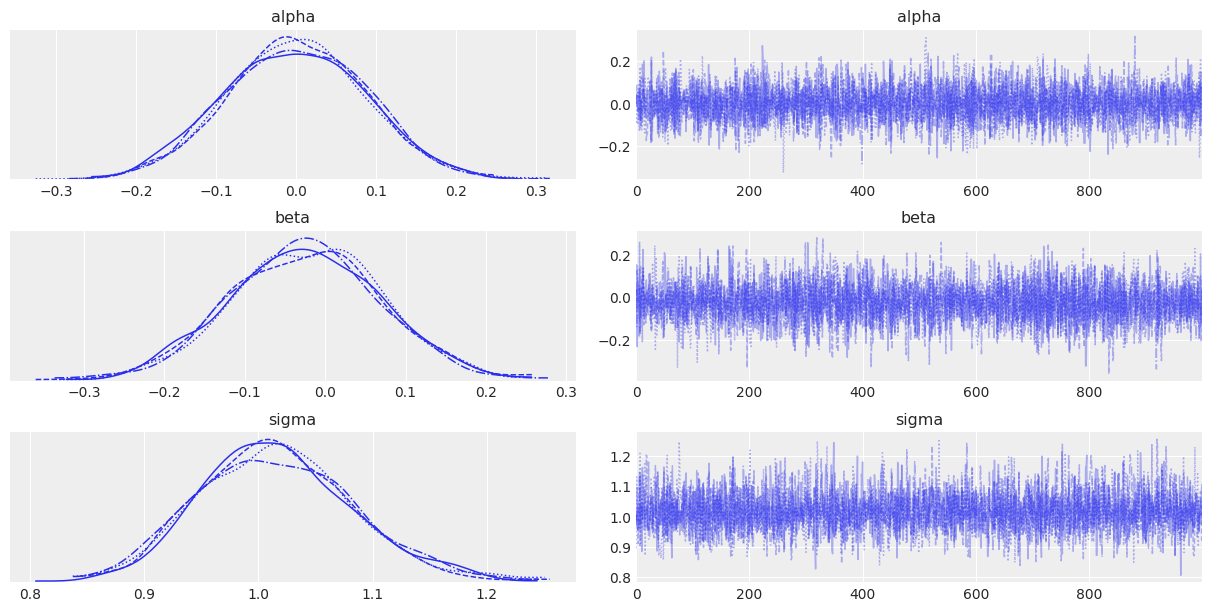

In [ ]:
pm.traceplot(trace_2)
plt.show()

In [ ]:
az.summary(trace_2, credible_interval=0.89)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.086,-0.160,0.161,0.001,0.002,5591.0,1571.0,5587.0,2537.0,1.0
beta,-0.024,0.094,-0.195,0.153,0.001,0.002,5767.0,1671.0,5764.0,2644.0,1.0
sigma,1.016,0.067,0.902,1.153,0.001,0.001,4493.0,4451.0,4488.0,2594.0,1.0


### Excercise 3

In [ ]:
with pm.Model() as model_3:
    # Data
    avgfood = pm.Data('avgfood', d['avgfood'].values)
    groupsize = pm.Data('groupsize', d['groupsize'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta = pm.Normal('beta', mu=0, sd=0.5)
    beta2 = pm.Normal('beta2', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta * avgfood + beta2 * groupsize
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior3 = pm.sample_prior_predictive(samples = 100)
    trace_3 = pm.sample()
    posterior_3 = pm.sample_posterior_predictive(trace_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta2, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8978675082186249, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
az.summary(trace_3, credible_interval=0.89)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.083,-0.154,0.160,0.001,0.002,3424.0,1447.0,3430.0,2432.0,1.0
beta,0.471,0.187,0.124,0.813,0.004,0.003,2262.0,2220.0,2260.0,2349.0,1.0
beta2,-0.568,0.187,-0.894,-0.199,0.004,0.003,2215.0,2175.0,2209.0,2204.0,1.0
sigma,0.972,0.065,0.847,1.091,0.001,0.001,2848.0,2791.0,2924.0,2277.0,1.0


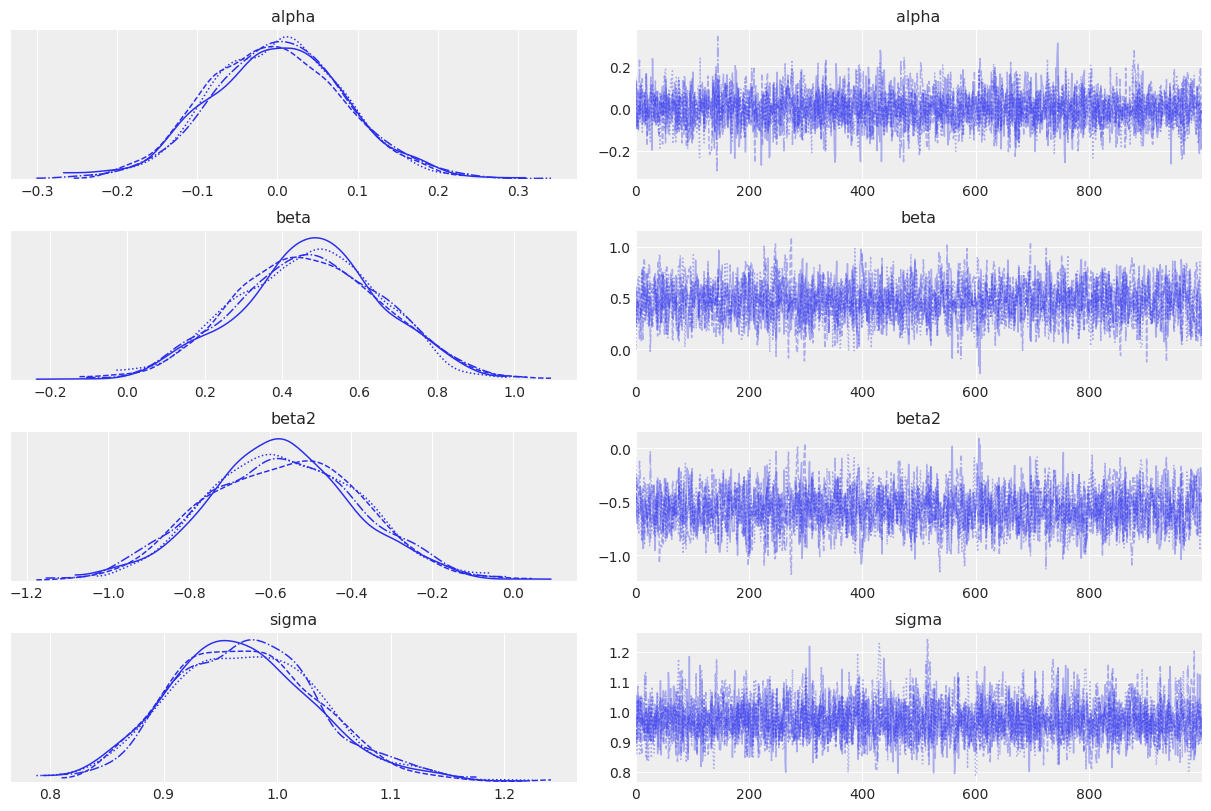

In [ ]:
pm.traceplot(trace_3)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f17b5f4ccd0>],
      dtype=object)

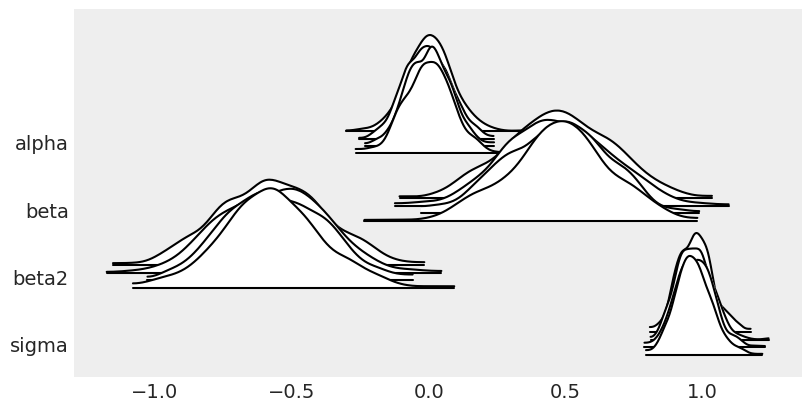

In [ ]:
az.plot_forest(trace_3, kind='ridgeplot', colors='white', figsize=(8,4))